# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

## Research Paper Link : https://arxiv.org/pdf/2010.11929

## Github Link : https://github.com/yogeshbawankar/PyTorch-Collection

Loading CIFAR-10...


100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Model Summary:

Training...
Epoch 1/5 | Loss: 1.8304 | Acc: 31.24%
Epoch 2/5 | Loss: 1.6738 | Acc: 38.18%
Epoch 3/5 | Loss: 1.7729 | Acc: 34.09%
Epoch 4/5 | Loss: 1.7596 | Acc: 34.79%
Epoch 5/5 | Loss: 1.7201 | Acc: 36.56%

Test Accuracy: 34.69%


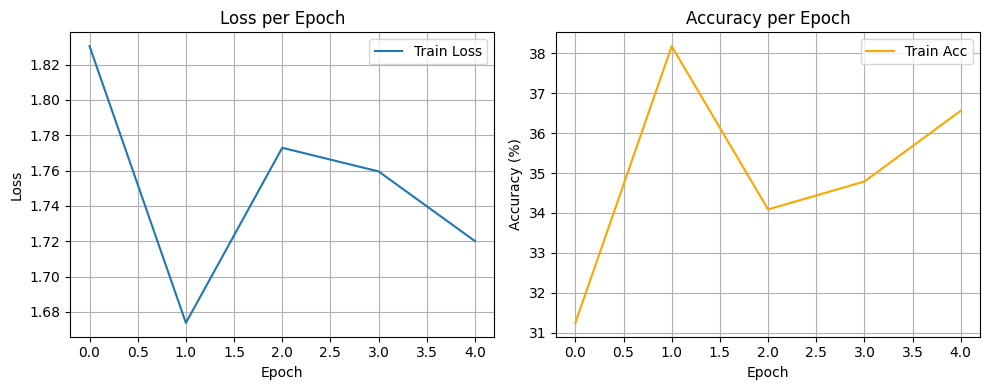

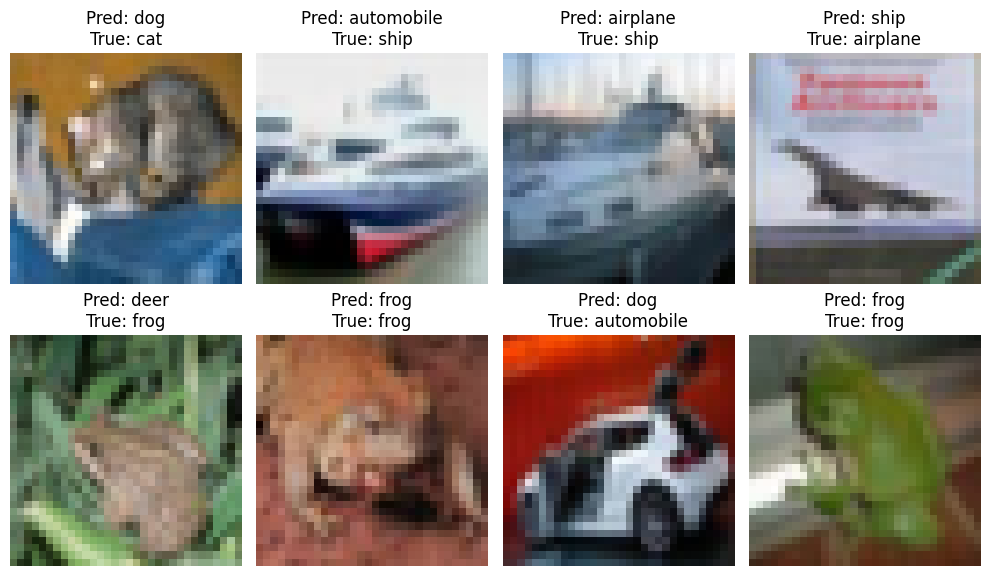

In [1]:
# ----------------------------------------------------------
# Mini-ViT: A Didactic Replication of
# "An Image is Worth 16x16 Words" (ICLR 2021)
# ----------------------------------------------------------
# Educational, end-to-end script:
#   CIFAR-10 -> Mini-ViT -> Train -> Evaluate -> Predict+Visualize
#
# Core ViT ideas implemented:
#   - Patch embedding via conv (kernel=stride=patch)
#   - Learnable [CLS] token + learnable 1D positional embeddings
#   - Pre-Norm Transformer blocks: LN -> MSA -> residual, LN -> MLP -> residual
#   - MLP head (linear for fine-tuning-style classification)
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
# 1) Dataset: CIFAR-10
# ==========================================================
print("Loading CIFAR-10...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

classes = train_dataset.classes
print("Classes:", classes)

# ==========================================================
# 2) Vision Transformer Components
# ==========================================================

class PatchEmbedding(nn.Module):
    """
    Patchify with a Conv2d where kernel_size=stride=patch_size.
    Outputs (B, N, D) where N = (H/patch_size)*(W/patch_size).
    """
    def __init__(self, in_ch=3, embed_dim=256, patch_size=4):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W) -> (B, D, H/ps, W/ps)
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x

class TransformerEncoderBlock(nn.Module):
    """
    Pre-Norm Transformer block:
      y = x + MSA(LN(x))
      z = y + MLP(LN(y))
    """
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=attn_drop)
        self.drop1 = nn.Dropout(proj_drop)

        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, dim),
        )
        self.drop2 = nn.Dropout(proj_drop)

    def forward(self, x):
        # MSA
        x = x + self.drop1(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
        # MLP
        x = x + self.drop2(self.mlp(self.norm2(x)))
        return x

class MiniViT(nn.Module):
    """
    Mini-ViT for CIFAR-10:
      - Patch size 4 over 32x32 -> 8x8=64 tokens
      - Add [CLS] token -> sequence length 65
      - Depth L, width D, heads H
    """
    def __init__(self, img_size=32, patch_size=4, in_ch=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=4, mlp_ratio=4.0, attn_drop=0.0, proj_drop=0.0):
        super().__init__()

        self.patch_embed = PatchEmbedding(in_ch, embed_dim, patch_size)
        num_patches = (img_size // patch_size) * (img_size // patch_size)

        # Learnable [CLS] token and positional embeddings (1D)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop  = nn.Dropout(proj_drop)

        # Transformer encoder
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, attn_drop, proj_drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # Classification head (linear, fine-tuning style)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize parameters (simple)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)                       # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)        # (B, 1, D)
        x = torch.cat([cls, x], dim=1)                # (B, N+1, D)
        x = x + self.pos_embed                        # add 1D positional encodings
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]                     # use [CLS] token
        logits = self.head(cls_token_final)
        return logits

# (Optional) Model summary if torchinfo is available
try:
    from torchinfo import summary
    print("\nModel Summary:")
    summary(
        model=MiniViT(),
        input_size=(1, 3, 32, 32),
        col_names=("input_size", "output_size", "num_params", "trainable"),
        col_width=20,
        row_settings=("var_names",)
    )
except Exception as e:
    print("torchinfo not available for summary (optional).")

# ==========================================================
# 3) Training
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniViT(embed_dim=256, depth=6, num_heads=4, patch_size=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

num_epochs = 5
train_loss_hist, train_acc_hist = [], []

print("\nTraining...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100.0 * correct / total
    train_loss_hist.append(epoch_loss)
    train_acc_hist.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# ==========================================================
# 4) Evaluation
# ==========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

test_acc = 100.0 * correct / total
print(f"\nTest Accuracy: {test_acc:.2f}%")

# ==========================================================
# 5) Visualizations: Curves + Predictions
# ==========================================================
# Training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label="Train Acc", color="orange")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions on a sample of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = outputs.max(1)

def imshow(img, title):
    # Unnormalize for display (mean=0.5, std=0.5)
    img = img * 0.5 + 0.5
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()

In [2]:
!pip install -q torchinfo
from torchinfo import summary
summary(
    model=model,                     # your model (e.g., MiniConvNeXt or MiniSwin)
    input_size=(1, 3, 32, 32),       # batch=1, 3-channel RGB, 32x32 image
    col_names=("input_size", "output_size", "num_params", "trainable"),
    col_width=20,                    # widen columns for readability
    row_settings=("var_names",)      # show variable (layer) names for clarity
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MiniViT (MiniViT)                             [1, 3, 32, 32]       [1, 10]              16,896               True
├─PatchEmbedding (patch_embed)                [1, 3, 32, 32]       [1, 64, 256]         --                   True
│    └─Conv2d (proj)                          [1, 3, 32, 32]       [1, 256, 8, 8]       12,544               True
├─Dropout (pos_drop)                          [1, 65, 256]         [1, 65, 256]         --                   --
├─ModuleList (blocks)                         --                   --                   --                   True
│    └─TransformerEncoderBlock (0)            [1, 65, 256]         [1, 65, 256]         --                   True
│    │    └─LayerNorm (norm1)                 [1, 65, 256]         [1, 65, 256]         512                  True
│    │    └─LayerNorm (norm1)                 [1, 65, 256]         [1, 65, 256]      